In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image, ImageOps
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
from IPython.display import clear_output

IMAGES_PATH = "drive/MyDrive/Brain Tumor Prediction/Brain Tumor/Brain Tumor"
LABELS_FILE = "drive/MyDrive/Brain Tumor Prediction/Brain Tumor.csv"

class dataset(
    torch.utils.data.Dataset
    ):

  def __init__(
      self,
      train=True,
      seed=1
      ):
    
    random.seed(seed)

    info = pd.read_csv(LABELS_FILE).set_index("Image").T.to_dict()

    image_paths_n, image_paths_y = [], []

    for f in os.listdir(IMAGES_PATH):

      label = info[re.search("^\w+", f)[0]]["Class"]
      image_path = os.path.join(IMAGES_PATH, f)

      if label == 0:

        image_paths_n.append(image_path)

      else:

        image_paths_y.append(image_path)
    
    random.shuffle(image_paths_n)
    random.shuffle(image_paths_y)

    samples_per_class = min(len(image_paths_n), len(image_paths_y))
    samples_set = [0, int(0.8 * samples_per_class)] if train else [int(0.8 * samples_per_class), samples_per_class]

    self.image_paths = image_paths_n[samples_set[0]:samples_set[1]] + image_paths_y[samples_set[0]:samples_set[1]]
    self.labels = [0] * (samples_set[1] - samples_set[0]) + [1] * (samples_set[1] - samples_set[0])
    self.train = train

  def __getitem__(
      self, 
      idx
      ):
    
    image_path, label = self.image_paths[idx], self.labels[idx]

    image = Image.open(image_path).convert("RGB")
    image = image.resize((128, 128))

    if self.train:

      transform = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomVerticalFlip(p=0.5),
          transforms.RandomRotation(degrees=(0, 360)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

    else:

      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

    image = transform(image)
    label = torch.tensor([label], dtype=torch.float32)
    
    return image, label

  def __len__(
      self
      ):

    return len(self.image_paths)

In [ ]:
train_dataset = dataset(train=True)
test_dataset = dataset(train=False)

x = PrettyTable(["Set", "Number of Samples"])
x.add_row(["Train", f"{len(train_dataset)} (50 % with tumor, 50 % without tumor)"])
x.add_row(["Test ", f"{len(test_dataset)} (50 % with tumor, 50 % without tumor)"])

print(x)

+-------+--------------------------------------------+
|  Set  |             Number of Samples              |
+-------+--------------------------------------------+
| Train | 2692 (50 % with tumor, 50 % without tumor) |
| Test  | 674 (50 % with tumor, 50 % without tumor)  |
+-------+--------------------------------------------+


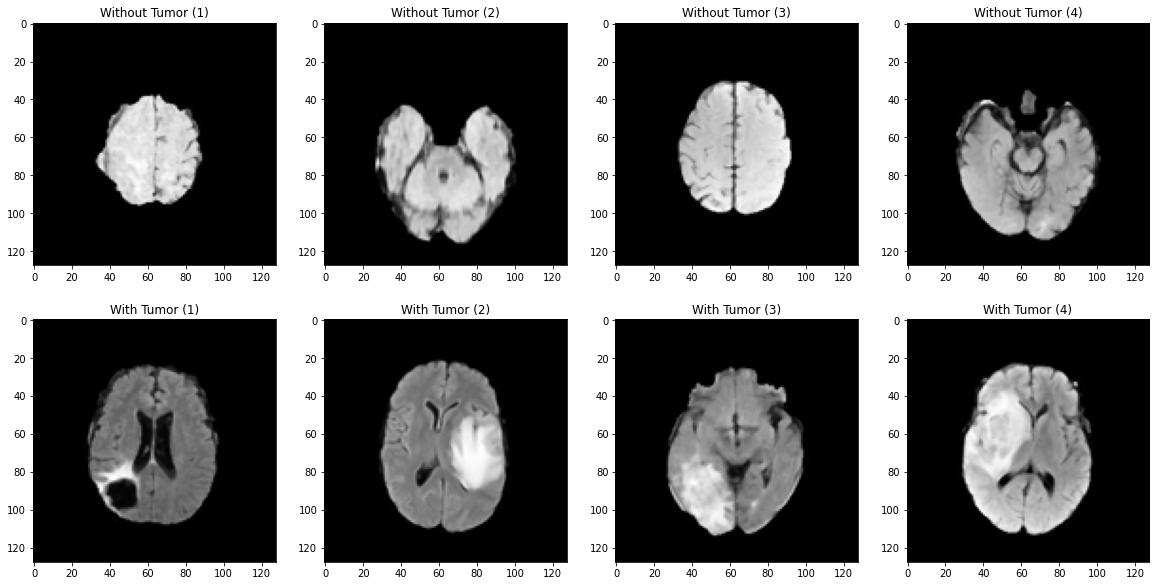

In [ ]:
image_n_1 = Image.open(train_dataset.image_paths[0]).convert("RGB").resize((128, 128))
image_n_2 = Image.open(train_dataset.image_paths[1]).convert("RGB").resize((128, 128))
image_n_3 = Image.open(train_dataset.image_paths[2]).convert("RGB").resize((128, 128))
image_n_4 = Image.open(train_dataset.image_paths[3]).convert("RGB").resize((128, 128))
image_y_1 = Image.open(train_dataset.image_paths[-1]).convert("RGB").resize((128, 128))
image_y_2 = Image.open(train_dataset.image_paths[-2]).convert("RGB").resize((128, 128))
image_y_3 = Image.open(train_dataset.image_paths[-3]).convert("RGB").resize((128, 128))
image_y_4 = Image.open(train_dataset.image_paths[-4]).convert("RGB").resize((128, 128))

plt.figure(figsize=(20, 10))

plt.subplot(241)
plt.imshow(image_n_1)
plt.title("Without Tumor (1)")

plt.subplot(242)
plt.imshow(image_n_2)
plt.title("Without Tumor (2)")

plt.subplot(243)
plt.imshow(image_n_3)
plt.title("Without Tumor (3)")

plt.subplot(244)
plt.imshow(image_n_4)
plt.title("Without Tumor (4)")

plt.subplot(245)
plt.imshow(image_y_1)
plt.title("With Tumor (1)")

plt.subplot(246)
plt.imshow(image_y_2)
plt.title("With Tumor (2)")

plt.subplot(247)
plt.imshow(image_y_3)
plt.title("With Tumor (3)")

plt.subplot(248)
plt.imshow(image_y_4)
plt.title("With Tumor (4)")

plt.show()

In [ ]:
class data_loader():

    def __init__(
        self,
        train_dataset,
        test_dataset
        ):
      
      train_batch_size, test_batch_size = 32, len(test_dataset)
      num_workers = 1

      self.train_loader = torch.utils.data.DataLoader(
          train_dataset, 
          batch_size=train_batch_size,
          shuffle=True,
          drop_last=True,
          num_workers=num_workers
          )

      self.test_loader = torch.utils.data.DataLoader(
          test_dataset, 
          batch_size=test_batch_size,
          shuffle=True,
          drop_last=True,
          num_workers=num_workers
          )

In [ ]:
class my_model(
    nn.Module
    ): 

    def __init__(
        self
        ):

        super(my_model, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.drop = nn.Dropout1d(p=0.25)
        self.fc_1 = nn.Linear(4608, 256)
        self.fc_2 = nn.Linear(256, 1)

    def forward(
        self, 
        x
        ):
      
        x = F.relu(F.max_pool2d(self.conv_1(x), 2))
        x = F.relu(F.max_pool2d(self.conv_2(x), 2))
        x = F.relu(F.max_pool2d(self.conv_3(x), 2))
        x = F.relu(F.max_pool2d(self.conv_4(x), 2))
        x = x.view(x.shape[0], -1)
        x = self.drop(x)
        x = F.relu(self.fc_1(x))
        x = torch.sigmoid(self.fc_2(x))
        
        return x

In [ ]:
class my_agent():

  def __init__(
      self,
      train_dataset,
      test_dataset
      ):

    self.data_loader = data_loader(train_dataset, test_dataset)
    self.model = my_model()

    if torch.cuda.is_available():

      torch.cuda.manual_seed(1)
      self.device = torch.device('cuda')
      torch.cuda.set_device(0)

    else:

      self.device = torch.device('cpu')
      torch.manual_seed(1)

    self.model.to(self.device)

    learning_rate = 1e-4 # 5e-5
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    self.criterion = nn.BCELoss()

    self.current_epoch, self.epochs = 0, 100
    self.train_losses, self.test_losses, self.test_accuracy, self.test_tpr, self.test_tnr = [], [], [], [], []

  def run(
      self
      ):

    for epoch in range(1, self.epochs + 1):

      self.current_epoch += 1
      self.train_epoch()
      self.test_epoch()

      if self.test_accuracy[-1] == max(self.test_accuracy):

        self.best_model = copy.deepcopy(self.model)
        self.best_test_accuracy = "{:.2f}".format(self.test_accuracy[-1])
        self.best_test_tpr = "{:.2f}".format(self.test_tpr[-1])
        self.best_test_tnr = "{:.2f}".format(self.test_tnr[-1])

      print(f"Epoch [{self.current_epoch}/{self.epochs}]")
      print(f"Best Model: (1) Accuracy: {self.best_test_accuracy} %, (2) TPR: {self.best_test_tpr} %, (3) TNR: {self.best_test_tnr} %")

      plt.figure()
      plt.plot(np.arange(1, self.current_epoch + 1), self.train_losses, linewidth=3, color=[1,0.3,0], label="Train")
      plt.plot(np.arange(1, self.current_epoch + 1), self.test_losses, linewidth=3, color=[0,0.3,1], label="Test")
      plt.legend()
      plt.xlabel("Epoch")
      plt.ylabel("BCE Loss")
      plt.title("Running Loss Plot")
      plt.show()

      clear_output(wait=True)

  def train_epoch(
      self
      ):
    
    self.model.train()

    train_loss = 0.0
    
    for (images, labels) in self.data_loader.train_loader:

      images = images.to(self.device)
      labels = labels.to(self.device)

      outputs = self.model(images)

      loss = self.criterion(outputs, labels)
      loss.backward()

      self.optimizer.step()
      self.optimizer.zero_grad()

      train_loss += loss.item() * images.size(0)

    self.train_losses.append(train_loss / len(self.data_loader.train_loader.sampler))

  def test_epoch(
      self
      ):
    
    self.model.eval()

    test_loss = 0.0
    total, correct = 0, 0
    total_negative, correct_negative = 0, 0
    total_positive, correct_positive = 0, 0

    with torch.no_grad():

      for (images, labels) in self.data_loader.test_loader:

        images = images.to(self.device)
        labels = labels.to(self.device)

        outputs = self.model(images)

        loss = self.criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        predicted = outputs > torch.tensor([0.5]).to(self.device)

        total += labels.size(0)
        total_negative += (labels == 0).sum().item()
        total_positive += (labels == 1).sum().item()

        correct += (predicted == labels).sum().item()
        correct_negative += ((predicted == 0).type(torch.uint8) + (labels == 0).type(torch.uint8) == 2).sum().item()
        correct_positive += ((predicted == 1).type(torch.uint8) + (labels == 1).type(torch.uint8) == 2).sum().item()

    self.test_losses.append(test_loss / len(self.data_loader.test_loader.sampler))
    self.test_accuracy.append(100 * correct / total)
    self.test_tnr.append(100 * correct_negative / total_negative)
    self.test_tpr.append(100 * correct_positive / total_positive)

Epoch [100/100]
Best Model: (1) Accuracy: 97.77 %, (2) TPR: 97.03 %, (3) TNR: 98.52 %


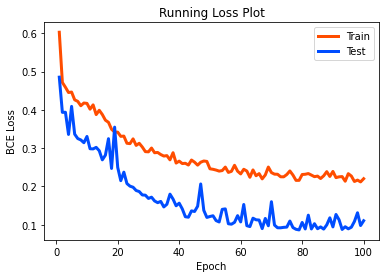

In [ ]:
agent = my_agent(train_dataset, test_dataset)
agent.run()

In [ ]:
agent.best_model.eval()

Y, Y_pred, Y_sus = [], [], [[] for i in range(100)]
thresholds = np.linspace(0, 0.5, len(Y_sus)).tolist()

for (images, labels) in agent.data_loader.test_loader:

  images = images.to(agent.device)
  Y += labels.cpu().detach().tolist()

  outputs = agent.best_model(images).cpu().detach()
  Y_pred += (outputs > torch.tensor([0.5])).type(torch.float32).tolist()

  for j, threshold in enumerate(thresholds):

    Y_sus[j] += (outputs > torch.tensor([threshold])).type(torch.float32).tolist()

x = PrettyTable(["Test Accuracy", "Test TPR (True Positive Rate)", "Test TNR (True Negative Rate)"])
x.add_row([f"{agent.best_test_accuracy} %", f"{agent.best_test_tpr} %", f"{agent.best_test_tnr} %"])

print(x)

+---------------+-------------------------------+-------------------------------+
| Test Accuracy | Test TPR (True Positive Rate) | Test TNR (True Negative Rate) |
+---------------+-------------------------------+-------------------------------+
|    97.77 %    |            97.03 %            |            98.52 %            |
+---------------+-------------------------------+-------------------------------+


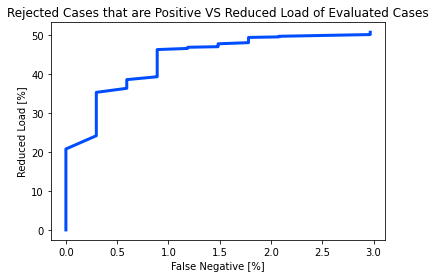

In [ ]:
total_positive, false_negative, reduced_load = 0, [0] * len(Y_sus), [0] * len(Y_sus)

for i in range(len(Y)):

  if Y[i][0] == 1:

    total_positive += 1

  for j in range(len(Y_sus)):

    if Y_sus[j][i][0] == 0:

      reduced_load[j] += 1

      if Y[i][0] == 1:

        false_negative[j] += 1

false_negative = np.array(false_negative) / total_positive * 100
reduced_load = np.array(reduced_load) / len(Y) * 100

plt.figure()
plt.plot(false_negative, reduced_load, color=[0,0.3,1], linewidth=3)
plt.xlabel("False Negative [%]")
plt.ylabel("Reduced Load [%]")
plt.title("Rejected Cases that are Positive VS Reduced Load of Evaluated Cases")
plt.show()

In [ ]:
x = PrettyTable(["Reduced Load", "Positive Rejected Cases"])
x.add_row(["50.74 %", "2.97 %"])
x.add_row(["20.77 %", "0.00 %"])

print(x)

+--------------+-------------------------+
| Reduced Load | Positive Rejected Cases |
+--------------+-------------------------+
|   50.74 %    |          2.97 %         |
|   20.77 %    |          0.00 %         |
+--------------+-------------------------+


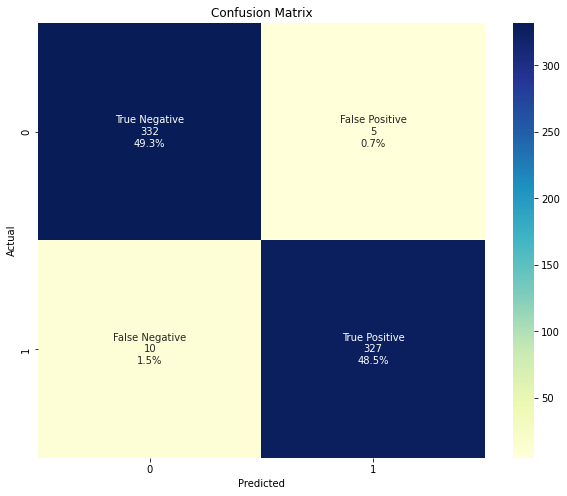

In [ ]:
cf_matrix = confusion_matrix(Y, Y_pred)
cf_vector = cf_matrix.flatten() / np.sum(cf_matrix)

plt.figure(figsize = (10,8))

classes = ["True Negative", "False Positive", "False Negative", "True Positive"]
number = [cf_matrix[0][0], cf_matrix[0][1], cf_matrix[1][0], cf_matrix[1][1]]
percentages = ["{0:.1%}".format(x) for x in cf_vector]

combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, number, percentages)]
combined = np.asarray(combined).reshape(2,2)

sns.heatmap(cf_matrix, annot=combined, fmt="", cmap='YlGnBu')
plt.title(f"Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()